In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid

class ChewC:
    def __init___(self):
        self.trait = None
        self.genome = None
        self.population = None
        self.pedigree_book = None

        
class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Individual:
    def __init__(self, genome,haplotype=None, mother = None, father = None, descendants = 0, source='founder', chewc=None):
        self.genome = genome  # must be Genome class
        self.haplotype = None
        self.source = source  # 'founder', 'cross', 'self', 'dh'
        self.descendents = []
        self.fitness = 0
        self.mother, self.father = mother, father

        # Logic for setting haplotype,mother,father
        if self.source == 'founder':
            self.haplotype= self._generate_random_haplotype()
        else:
            self.haplotype = haplotype
            
        self.make_id()
            
    def __repr__(self):
        return f'Individual with haplotype shape: {self.haplotype.shape}'
    
    def make_id(self):self.id = uuid.uuid4().hex


    def _generate_random_haplotype(self):
        """Generate a random haplotype for the individual."""
        return np.random.choice([0, 1], size=(self.genome.ploidy, self.genome.n_chr, self.genome.n_loci))

    def gamete(self):
        haplotypes = self.haplotype
        def shuffle_chr(chromosome_pair):
            """
            Perform crossover on a pair of chromosomes.

            Parameters:
            chromosome_pair (list): A list of two equal length lists representing chromosomes.

            Returns:
            list: A new chromosome formed by shuffling the given chromosome pair.
            """
            # Ensure the chromosome pair contains two chromosomes of equal length
            assert len(chromosome_pair) == 2
            assert len(chromosome_pair[0]) == len(chromosome_pair[1])

            # Number of crossover points, sampled from a Poisson distribution with λ=1.3
            n_crossover = np.random.poisson(1.3)

            # Determine crossover locations, sampled without replacement from chromosome length
            chromosome_length = len(chromosome_pair[0])
            crossover_locs = np.sort(np.random.choice(chromosome_length, n_crossover, replace=False))

            # Initialize the new chromosome and set the current chromosome to the first one
            new_chromosome = []
            current_chr = 0

            # Perform crossover by alternating segments between the two chromosomes
            last_loc = 0
            for loc in crossover_locs:
                new_chromosome.extend(chromosome_pair[current_chr][last_loc:loc])
                current_chr = 1 - current_chr  # Switch to the other chromosome
                last_loc = loc

            # Append the remaining segment
            new_chromosome.extend(chromosome_pair[current_chr][last_loc:])
            return np.array(new_chromosome)

        # Initialize an empty array to store the shuffled chromosomes
        shuffled_haplotypes = np.zeros_like(haplotypes)
        ploidy, n_chr, n_loci = chewc.genome.shape
        # Iterate over each chromosome and apply the shuffle_chr function
        for i in range(haplotypes.shape[1]):  # Iterate over the chromosomes
            chromosome_pair = haplotypes[:, i, :]  # Extract the chromosome pair (2, 77)
            shuffled_chromosome = shuffle_chr(chromosome_pair)  # Shuffle the chromosome pair    
            shuffled_haplotypes[:, i, :] = np.array(shuffled_chromosome).reshape(1, n_loci)  # Store the shuffled chromosome
        return shuffled_haplotypes[0,:,:]

    def phenotype(self, environmental_variance):
        """
        Calculate the phenotype for the individual.

        Args:
            h2 (float): Heritability of the trait.
            environmental_variance (float): The calculated environmental variance for the population.
        """
        breeding_value = chewc.trait @ self 
        phenotype_value = breeding_value + np.random.normal(0, np.sqrt(environmental_variance))
        self.fitness = np.sum(phenotype_value) + chewc.trait.intercept

    def X(self, partner):
        if isinstance(partner,Individual):
            source = 'cross'
            progeny_haplo = np.stack((self.gamete(), partner.gamete()))
            progeny = Individual(self.genome, progeny_haplo, self.id, partner.id,source=source, chewc = chewc)
            return progeny

class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance):
        #store attributes
        self.target_mean = target_mean
        self.target_variance = target_variance
        
        initial_effects = np.random.randn(g.n_chr * g.n_loci) #sample initi random effects from N distribution
        initial_effects -= initial_effects.mean() #explicitly set the mean to 0
        
        pop_scores = np.sum(founder_population.get_haplo(),axis=1).reshape(founder_population.size, g.n_chr*g.n_loci)
        founder_scores = np.sum(initial_effects*pop_scores,axis=1)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = np.sqrt(self.target_variance / founder_var)
        initial_effects *= scaling_factors
        scaled_effects = initial_effects
        self.effects = scaled_effects
        self.intercept = target_mean - founder_mean

    def __matmul__(self,other):
        if isinstance(other,Individual):
    #             print(f' intercept {self.intercept}')
            breeding_value = self.effects * np.sum(other.haplotype,axis=0).flatten()
            return breeding_value
        else:
            print('ffff')




    

In [ ]:
class Population:
    def __init__(self, genome, individuals=None, size=None):
        self.genome = genome
        self.ploidy = 2
        if size:
            self.size = size
            self.individuals = self._create_initial_population()
        else:
            self.individuals = individuals

    def _create_initial_population(self):
        """Create an initial population of founder individuals."""
        return [Individual(self.genome) for _ in range(self.size)]
    
    def get_haplo(self):
        return np.array([x.haplotype for x in self.individuals])
    
    def get_pheno(self):
        return np.array([x.fitness for x in self.individuals])
    
    def __getitem__(self, index):
        return self.individuals[index]

    def __repr__(self):
        print('pop class')
#         return f'Population of size: {len(self.individuals)}'

    def breed(self, breeding_plan):
        """
        Creates a new population based on a breeding plan.

        Args:
            breeding_plan (list): A list of tuples, where each tuple is a pair of parent indexes.
        """
        new_individuals = []
        for parent1_index, parent2_index in breeding_plan:
            parent1 = self.individuals[parent1_index]
            parent2 = self.individuals[parent2_index]
            progeny = parent1.X(parent2)  # Use the existing `__mul__` for mating
            new_individuals.append(progeny)

        chewc.pedigree_book.append(self)
        chewc.population = Population(g,new_individuals)
    #     self.individuals = new_individuals  # Replace the current population
    
    def trial(self, h2):
        """
        Simulate phenotypes for all individuals in the population.

        Args:
            h2 (float): Heritability of the trait.
        """
        # 1. Calculate environmental variance at the population level
        population_genetic_variance = np.var(chewc.population.get_pheno(), ddof=1)
        environmental_variance = (1 - h2) / h2 * population_genetic_variance

        # 2. Phenotype each individual, passing the environmental variance
        for individual in self.individuals:
            individual.phenotype(environmental_variance)


    def truncation(self, top_percent):
        """
        Returns the indexes of phenotypes in the top percent.

        Args:
            top_percent (float): The top percentage of individuals to select (0 < top_percent <= 100).
        """
        # Ensure the top_percent is within the valid range
        if top_percent <= 0 or top_percent > 100:
            raise ValueError("top_percent must be between 0 and 100")

        # Calculate the number of individuals to select
        num_to_select = int(population.size * top_percent / 100)

        # Get the phenotypes of all individuals
        phenotypes = self.get_pheno()
        assert phenotypes.sum() != 0, 'no phenotypes present'
    #     print(phenotypes)

        # Get the indices that would sort the array in descending order
        sorted_indices = np.argsort(phenotypes)[::-1]

        # Select the top individuals based on the sorted indices
        top_indices = sorted_indices[:num_to_select]

        return top_indices


In [ ]:
def random_pairs_with_resampling(arr, n_pairs):
    """
    Return n_pairs of randomly selected integers from the given array, with resampling.
    
    Parameters:
    arr (numpy.ndarray): A numpy array of integers.
    n_pairs (int): The number of pairs to return.
    
    Returns:
    list of tuples: A list of tuples, each containing a pair of randomly selected integers.
    """
    pairs = []
    for _ in range(n_pairs):
        pair = tuple(np.random.choice(arr, size=2, replace=True))
        pairs.append(pair)
    return pairs

In [ ]:
pop_size = 200
g = Genome(3, 1000)
population = Population(g, size=pop_size)
trait = Trait(g, population,0,1)

h2 = .01


#Plug them into ChewC
chewc = ChewC()
chewc.trait = trait
chewc.population = population
chewc.genome = g
chewc.pedigree_book = []
chewc.population.trial(h2)


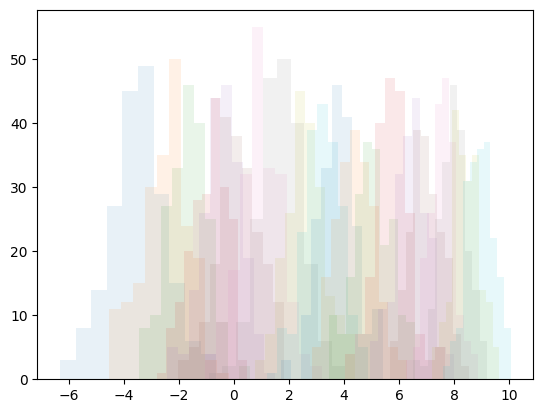

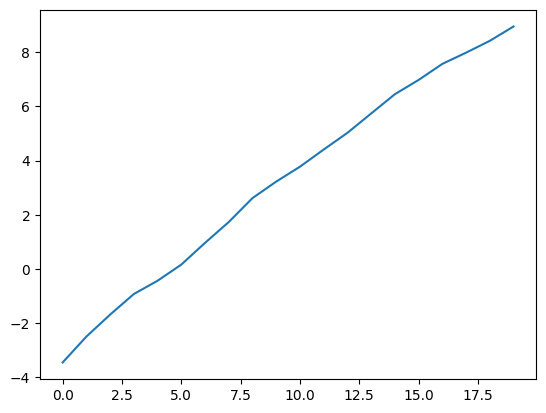

In [ ]:
means = []
for _ in range(20):
    means.append(chewc.population.get_pheno().mean())
    plt.hist(chewc.population.get_pheno(),alpha=.1)
    selection = random_pairs_with_resampling(chewc.population.truncation(40), pop_size)
    chewc.population.breed(selection)
    chewc.population.trial(h2)
plt.show()
plt.plot(means)
plt.show()